In [1]:
import os.path

import segmentation_models_pytorch as smp
import torch
import yaml
import numpy as np
import wandb
import cv2
import pandas as pd

from utils.transformation import transform_batch, transform_mask
from utils.metrics import calculate_iou, calculate_iou_per_class, calculate_ap_for_segmentation
from data import BatchMaker, process_mask

In [2]:
import matplotlib.pyplot as plt

In [3]:
batch_maker = BatchMaker(batch_size=1, annotator=1,
                              mode="mixed", work_mode="test")
test_loader = batch_maker.test_loader

D:\SEGMENTACJA\SegSperm_part\SegSperm_part/test/GT1_mixed
(119,)
X shape: (119, 512, 512, 3)
y shape: (119, 512, 512, 4)


In [4]:
with open("path_config.yaml", 'r') as config_file:
    yaml_config = yaml.safe_load(config_file)

# saved_model_name = 'One segment lossA=1 k=5 M=smpUNet++ aug=False mode=multiclass Opt=Adam Sch=CosineAnnealingLR E=2 B_size=6 lr=0.001 Loss=CrossEntropyLoss date=13-08-2024-19-03_best_model_iou_multiclass'
# model_path = yaml_config['save_model_path'] + '/' + saved_model_name

# model = smp.UnetPlusPlus(in_channels=3, classes=4, encoder_name="resnet18", encoder_weights=None)
# model.load_state_dict(torch.load(model_path))

In [5]:
torch.cuda.is_available()

True

In [80]:
# model_name = r"One_segment_lossAnnotator_1_k=5_Model_smpUNet++_Augmentation_False_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_200_Batch_Size_6_S.001_Loss_CrossEntropyLoss_Timestamp_2024-08-06-12-23_best_model_iou_multiclass"

model_name = r"One_segment_lossAnnotator_1_k=5_Model_smpUNet++_Augmentation_False_Modemulticlass_Optimizer_Adam_Scheduler_CosineAnnealingLR_Epochs_300_Batch_Size_6_Start_lr_0.001_Loss_CrossEntropyLoss_Timestamp_2024-07-23-17-00_best_model_iou_multiclass"



dir_ = r"D:\SEGMENTACJA\model/"

model_path_lab = dir_ + model_name

model = smp.UnetPlusPlus(in_channels=3, classes=4, encoder_name="resnet18", encoder_weights=None)
model.load_state_dict(torch.load(model_path_lab))
# model.load_state_dict(torch.load(model_path_lab, map_location=torch.device('cuda')))

C:\Users\Piotr\AppData\Local\Temp\ipykernel_7860\3947842996.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path_lab))


<All keys matched successfully>

In [81]:
def calculate_optimal_threshold(x_images, masks, softmask_multiclass, softmask_oneclass):

    # print(np.shape(masks))
    # print(type(masks))
    # print("calculate_optimal_threshold")
    
    labels1 = transform_batch(masks, 1)
    labels2 = transform_batch(masks, 2)

    # fig, ax = plt.subplots(1, 2)

    # plt.subplot(1, 2, 1)
    # plt.imshow(labels1[0])
    # plt.colorbar()

    # plt.subplot(1, 2, 2)
    # plt.imshow(labels2[0])
    # plt.colorbar()

    # labels1 = np.round(labels1).astype(np.int16)
    # labels2 = np.round(labels2).astype(np.int16)
    
    # print("labels1", np.shape(labels1))
    # print("labels2", np.shape(labels2))

    # thresholds = torch.linspace(0, 1, steps=255)

    thresholds = np.linspace(0, 1, 25)

    iou_multiclass = []
    iou_oneclass_array = []
    iou_head_array = []
    iou_tail_array = []
    iou_merge_array = []

    # fig, ax = plt.subplots(1, 6, figsize=(24, 8))
    
    # plt.subplots(1, 6)
    # plt.figure(figsize=(24, 8))

    # plt.subplot(1,6,1)
    # plt.imshow(np.transpose(softmask_multiclass[0], axes=(1,2,0)))
    
    softmask_multiclass_np = np.array(softmask_multiclass)
    softmask_oneclass_np = np.array(softmask_oneclass)

    # softmask_multiclass = np.transpose(softmask_multiclass, axes=(0, 3, 1, 2))
    # softmask_oneclass = np.transpose(softmask_oneclass, axes=(0, 3, 1, 2))

    # print("softmask_multiclass", np.shape(softmask_multiclass))
    # print("softmask_oneclass", np.shape(softmask_oneclass))

    # if multiclass xd

    # softmask_tail = np.array(softmask_multiclass_np[:, :, :, 1])
    # softmask_head = np.array(softmask_multiclass_np[:, :, :, 2])
    softmask_tail = np.array(softmask_multiclass_np[:, 1, :, :])
    softmask_head = np.array(softmask_multiclass_np[:, 2, :, :])

    plt.subplots(1, 4)
    plt.suptitle("softmasks before merge")

   
    plt.subplot(1, 4, 1)
    plt.imshow(softmask_tail[0,:,:])
    plt.title("tail 0")

    plt.subplot(1, 4, 2)
    plt.imshow(softmask_tail[1,:,:])
    plt.title("tail 1")

    plt.subplot(1, 4, 3)
    plt.imshow(softmask_head[0,:,:])
    plt.title("head 0")

    plt.subplot(1, 4, 4)
    plt.imshow(softmask_head[1,:,:])
    plt.title("head 1")
    
    # plt.subplot(1,6,2)
    # plt.imshow(softmask_tail[0])
    # plt.title("tail")

    # plt.subplot(1,6,3)
    # plt.imshow(softmask_head[0])
    # plt.title("head")
    
    softmask_merge_multiclass = softmask_head + softmask_tail

    # plt.subplot(1,6,4)
    # # plt.imshow(softmask_merge_multiclass[0])
    # plt.contour(softmask_merge_multiclass[0])
    # plt.colorbar()
    # plt.title("no threshold")
    # plt.tight_layout()
    
    # print("softmask_tail", np.shape(softmask_tail))
    # print("softmask_head", np.shape(softmask_head))
    # print("softmask_merge", np.shape(softmask_merge_multiclass))

    # print("unique softmask", np.unique(softmask_merge_multiclass))
    # print(f"max softmax {np.max(softmask_merge_multiclass)}, min softmax {np.min(softmask_merge_multiclass)}")

    # stop
    # thresholds = np.array([0.1])
    for i, threshold in enumerate(thresholds):
        # pred_merge_multi = (softmask_merge_multiclass > threshold).astype(np.float32)
        pred_merge_multi = np.where(softmask_merge_multiclass > threshold, 1, 0).astype(float)
        
        pred_merge_multi = pred_merge_multi.squeeze()
        # print("pred_merge_multi", np.shape(pred_merge_multi))
        # print("labels2", np.shape(labels2))
        # iou_merge_multiclass, iou_merge_multiclass_list = calculate_iou(pred_merge_multi, labels2, 2)
        iou_merge_multiclass, iou_merge_multiclass_list = calculate_iou(pred_merge_multi, masks[:,1,:,:], 2) ###

        # dodaję wyniki do listy
        iou_merge_array.append(iou_merge_multiclass)
        
        plt.imshow(masks[0, 1, :,:])
        plt.title("mask")
        print(np.shape(masks))
        # iou_merge_multiclass = bin_iou(pred_merge_multi, labels2)
        # print("pred merge multi",np.unique(pred_merge_multi))
        # print("labels2", np.unique(pred_merge_multi))
        print(f"\n\nTHRESHOLD:   {threshold}: {iou_merge_multiclass}")
        print(iou_merge_multiclass_list)
        # continue
        # plt.imshow(pred_merge_multi-labels2)
        # plt.subplot(1, 6, 5)
        # plt.imshow(pred_merge_multi[0])
        # plt.title(f"pred_merge {threshold}")


        # plt.subplot(1, 6, 6)
        # plt.imshow(labels2[0])
        # plt.title(f"lbl")

        pred_mask_multi = (softmask_multiclass > threshold).astype(float)

        pred_mask_multi_tail = pred_mask_multi[:, 1, :, :]
        pred_mask_multi_head = pred_mask_multi[:, 2, :, :]

        plt.subplots(1, 4)

        plt.subplot(1, 4, 1)
        plt.imshow(pred_mask_multi_tail[0,:,:])
        plt.title("tail 0")

        plt.subplot(1, 4, 2)
        plt.imshow(pred_mask_multi_tail[1,:,:])
        plt.title("tail 1")
        
        plt.subplot(1, 4, 3)
        plt.imshow(pred_mask_multi_head[0,:,:])
        plt.title("head 0")

        plt.subplot(1, 4, 4)
        plt.imshow(pred_mask_multi_head[0,:,:])
        plt.title("head 1")
        
        iou_head, iou_head_list = calculate_iou(pred_mask_multi_head, masks[:, 2, :, :], 2) # a nie trzy klasy?

        iou_head_array.append(iou_head)

        
        iou_tail, iou_tail_list = calculate_iou(pred_mask_multi_tail, masks[:, 1, :, :], 2)

        iou_tail_array.append(iou_tail)

        

     
        
        # print("\n\npred_mask_multi_head", np.shape(pred_mask_multi_head))
        # print("pred_mask_multi_tail\n\n", np.shape(pred_mask_multi_tail))
        
        
        
        
        print("iou_head:", iou_head)
        print("iou_head_list:", iou_head_list)
        print("iou_tail:", iou_tail)
        print("iou_tail_list:", iou_tail_list)

        final_prediction = np.zeros_like(pred_merge_multi)
        # conflict_mask = np.zeros_like(final_prediction)
        # conflict_mask = (softmask_tail > softmask_head).astype(int)
        
        # print("final_pred ", np.shape(final_prediction))
        # print("conflict_mask ", np.shape(conflict_mask))

        conflict = (pred_mask_multi_head == 1) & (pred_mask_multi_tail == 1)
        # print("conflict ",np.shape(conflict))

        conflict_mask = np.zeros_like(final_prediction)
        conflict_mask = (softmask_tail[conflict] > softmask_head[conflict]).astype(int)
        #
        # final_prediction = pred_mask_multi_head + pred_mask_multi_tail
        final_prediction[conflict] = 2 - conflict_mask
        
        final_prediction[(pred_mask_multi_tail == 1) & ~conflict] = 1
        final_prediction[(pred_mask_multi_head == 1) & ~conflict] = 2

        fig, ax = plt.subplots(1, 2, figsize=(8,4))

        plt.subplot(1, 2, 1)
        plt.imshow(final_prediction[1,:,:])
        plt.title("final")

        plt.subplot(1, 2, 2)
        plt.imshow(labels1[1,:,:])
        plt.title("label1")
        
        final_iou, final_iou_list = calculate_iou(final_prediction, labels1, 3)

        iou_multiclass.append(final_iou)

        print("final_iou:", final_iou)
        print("final_list:", final_iou_list)

        # oneclass

        mask_oneclass = np.where(softmask_oneclass_np > threshold, 1, 0)
        onc_iou, onc_iou_list = calculate_iou(mask_oneclass, labels2, 2)

        iou_oneclass_array.append(onc_iou)

        print(f"iou_oneclass: {onc_iou}")
        print(f"iou_oneclass: {onc_iou_list}")

    print(f"BEST RESULTS")
    print(f"TAIL:        iou = {np.max(iou_tail_array)}      :: threshold {thresholds[np.where(iou_tail_array == np.max(iou_tail_array))]}")
    print(f"HEAD:        iou = {np.max(iou_head_array)}      :: threshold {thresholds[np.where(iou_head_array == np.max(iou_head_array))]}")
    print(f"MERGE:       iou = {np.max(iou_merge_array)}     :: threshold {thresholds[np.where(iou_merge_array == np.max(iou_merge_array))]}")
    print(f"MULTICLASS:  iou = {np.max(iou_multiclass)}      :: threshold {thresholds[np.where(iou_multiclass == np.max(iou_multiclass))]}")
    print(f"ONECLASS:    iou = {np.max(iou_oneclass_array)}  :: threshold {thresholds[np.where(iou_oneclass_array == np.max(iou_oneclass_array))]}")
    
    

In [8]:
def predict(model: torch.nn, test_loader, device = torch.device("cuda")):
    model.eval()
    true_masks = []
    input_imgs = []
    predicted_masks_multiclass = []
    predicted_masks_oneclass = []
    predicted_softmasks_multiclass = []
    predicted_softmasks_oneclass = []
    i = 0
    with torch.no_grad():
        model = model.to(device)
        for data in test_loader:
            images, labels = data
            labels = labels.cpu()
            labels = np.array(labels)

            images = images.to(device)
            outputs = model(images)

            output1 = outputs[:, :3, :, :]
            output2 = outputs[:, [0, 1], :, :]

            true_masks.append(labels.squeeze())    # ???
            input_imgs.append(images.cpu())

            preds1 = torch.argmax(output1, dim=1)
            preds2 = torch.argmax(output2, dim=1)


            plt.subplots(1, 2)

            plt.subplot(1, 2, 1)
            plt.imshow(preds1.cpu().squeeze())
            plt.title("pred1")

            plt.subplot(1, 2, 2)
            plt.imshow(preds2.cpu().squeeze())
            plt.title("pred2")

            softs1 = torch.softmax(output1, dim=1).squeeze(0)
            softs2 = torch.softmax(output2, dim=1).squeeze(0)

            plt.subplots(1, 3)
            plt.subplot(1, 3, 1)
            plt.imshow(np.transpose(softs1.cpu(), axes=(1,2,0)))
            plt.title("softs1")
            
            plt.subplot(1, 3, 2)
            # plt.imshow(np.transpose(softs2[:,:,0].cpu(), axes=(1,2,0)))
            plt.imshow(softs2[0,:,:].cpu())
            plt.title("softs2 0")

            plt.subplot(1, 3, 3)
            # plt.imshow(np.transpose(softs2[:,:,1].cpu(), axes=(1,2,0)))
            plt.imshow(softs2[1,:,:].cpu())
            plt.title("softs2 1")
            
            predicted_masks_multiclass.append(preds1.cpu())
            predicted_masks_oneclass.append(preds2.cpu())
            
            predicted_softmasks_multiclass.append(softs1.cpu())
            predicted_softmasks_oneclass.append(softs2.cpu())

            # print("\npredicted_masks_multiclass", np.shape(predicted_masks_multiclass))
            # print("predicted_masks_oneclass", np.shape(predicted_masks_oneclass))
            # print("predicted_softmasks_multiclass", np.shape(predicted_softmasks_multiclass))
            # print("predicted_softmasks_oneclass", np.shape(predicted_softmasks_oneclass))
            # print("labels", np.shape(labels))
            # print("true_masks", np.shape(true_masks))

            img = images.cpu().numpy()
            img = img/np.max(img)
            
            # plt.subplots(1, 2)

            # plt.subplot(1, 2, 1)
            # plt.imshow(np.transpose(softs1, axes=(1,2,0)))
            # # print("softs1:", np.unique(softs1))
            # plt.colorbar()
            # plt.subplot(1, 2, 2)
            # plt.imshow(np.transpose(img.squeeze(), axes=(1,2,0)))
            
            
            if i >= 1:
                break
            i+=1
        calculate_optimal_threshold(images, np.array(true_masks), predicted_softmasks_multiclass, predicted_softmasks_oneclass)

[0.         0.00378418]
[0.         0.00417709]
(2, 4, 512, 512)


THRESHOLD:   0.0: 0.0039806365966796875
[0.         0.00398064]
[0.         0.00203323]
[0.         0.00266266]
[0.99620819 0.        ]
[0.99581528 0.        ]
iou_head: 0.0023479461669921875
iou_head_list: [0.         0.00234795]
iou_tail: 0.0
iou_tail_list: [0.99601173 0.        ]
[0.         0.         0.00203323]
[0.         0.         0.00266266]
final_iou: 0.0011739730834960938
final_list: [0.         0.         0.00234795]
[0.45984901 0.00654814]
[0.48281921 0.0088025 ]
iou_oneclass: 0.007675321516785254
iou_oneclass: [0.47133411 0.00767532]
[0.         0.00378418]
[0.         0.00417709]
(2, 4, 512, 512)


THRESHOLD:   0.041666666666666664: 0.0039806365966796875
[0.         0.00398064]
[0.         0.00203323]
[0.         0.00266266]
[0.99621582 0.        ]
[0.99582291 0.        ]
iou_head: 0.0023479461669921875
iou_head_list: [0.         0.00234795]
iou_tail: 0.0
iou_tail_list: [0.99601936 0.        ]
[0.       

C:\Users\Piotr\AppData\Local\Temp\ipykernel_7860\62862289.py:204: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(8,4))


[3.82246924e-06 2.03324140e-03]
[3.82488162e-06 2.66266885e-03]
[0.99621582 0.        ]
[0.99582291 0.        ]
iou_head: 0.0023479551237301777
iou_head_list: [3.82367543e-06 2.34795512e-03]
iou_tail: 0.0
iou_tail_list: [0.99601936 0.        ]
[3.83701879e-06 0.00000000e+00 2.03324140e-03]
[3.84096854e-06 0.00000000e+00 2.66266885e-03]
final_iou: 0.0011739775618650888
final_list: [3.83899366e-06 0.00000000e+00 2.34795512e-03]
[0.49851844 0.00579107]
[0.49826312 0.00681566]
iou_oneclass: 0.006303362739470035
iou_oneclass: [0.49839078 0.00630336]
[3.82918760e-06 3.78419412e-03]
[3.83069845e-06 4.17710944e-03]
(2, 4, 512, 512)


THRESHOLD:   0.375: 0.003980651781661154
[3.82994303e-06 3.98065178e-03]
[3.82246924e-06 2.03324140e-03]
[3.82488162e-06 2.66266885e-03]
[0.99621582 0.        ]
[0.99582291 0.        ]
iou_head: 0.0023479551237301777
iou_head_list: [3.82367543e-06 2.34795512e-03]
iou_tail: 0.0
iou_tail_list: [0.99601936 0.        ]
[3.83701879e-06 0.00000000e+00 2.03324140e-03]
[3

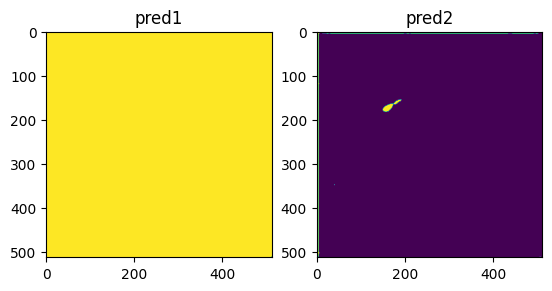

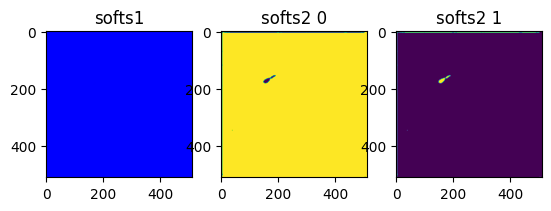

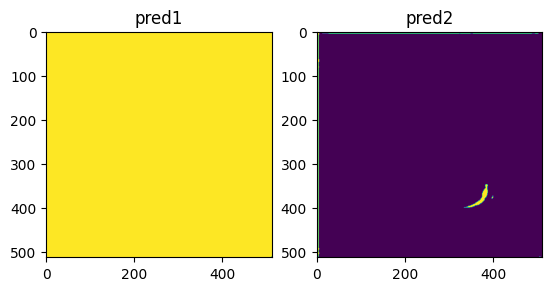

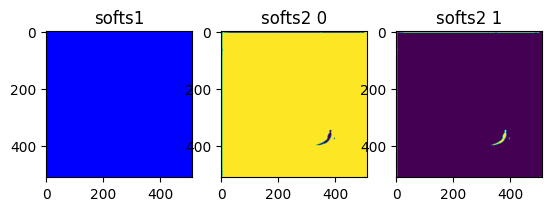

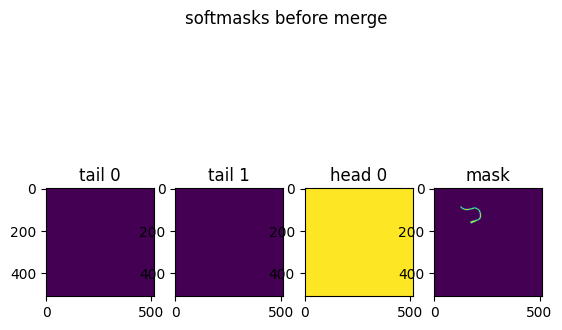

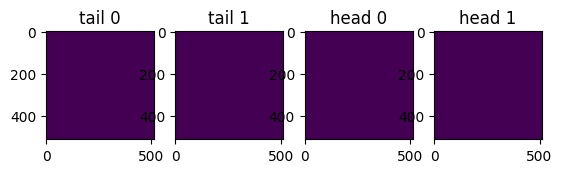

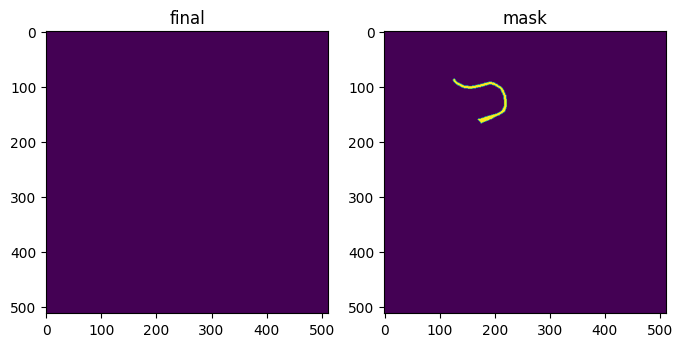

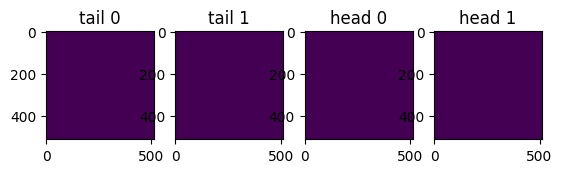

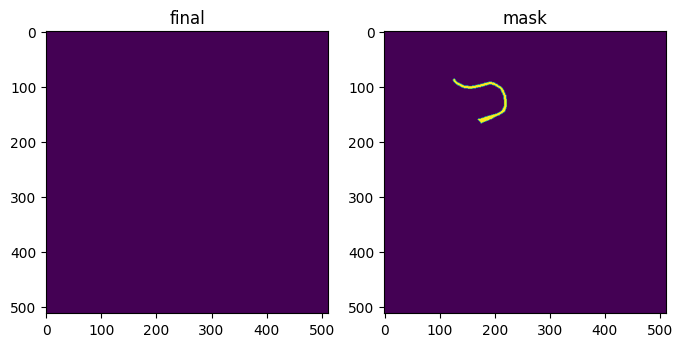

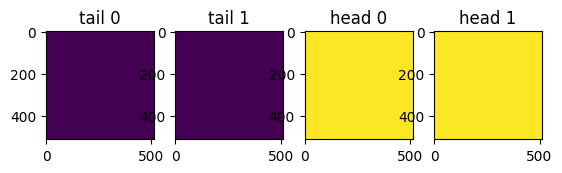

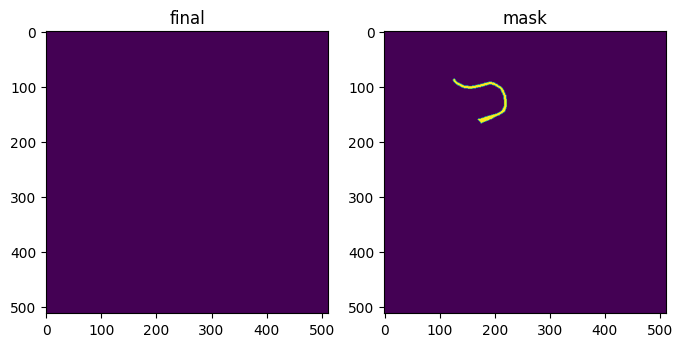

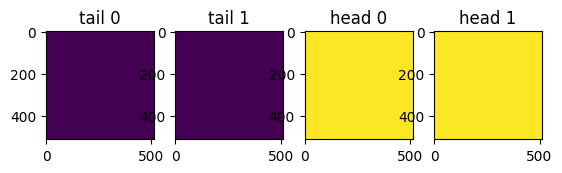

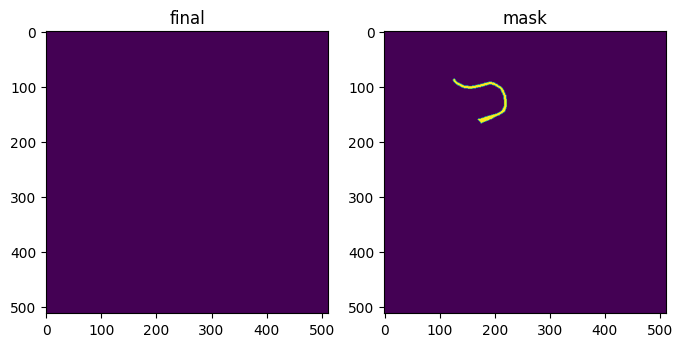

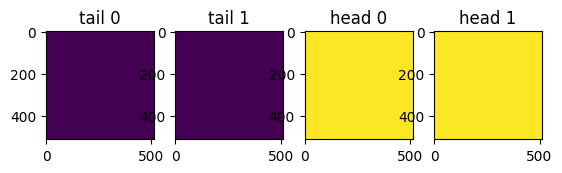

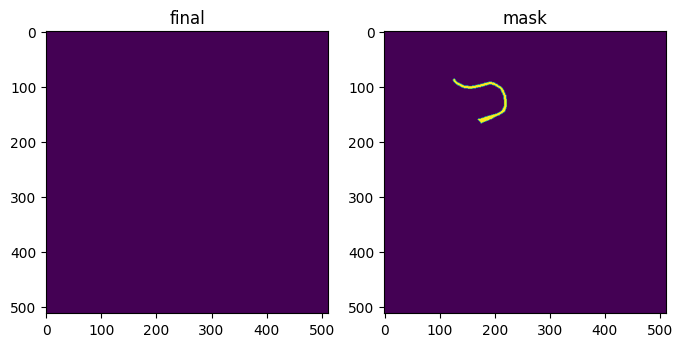

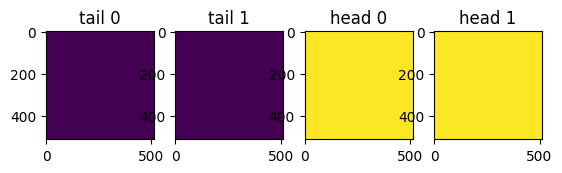

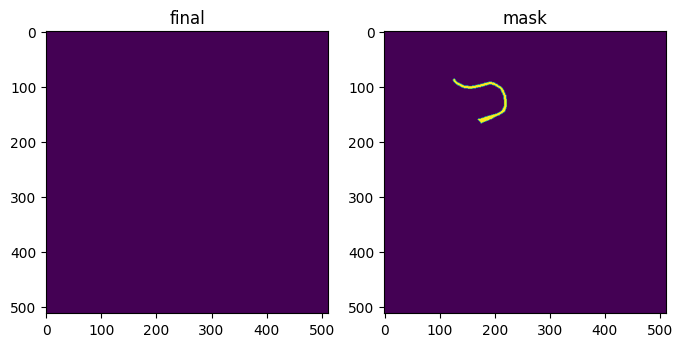

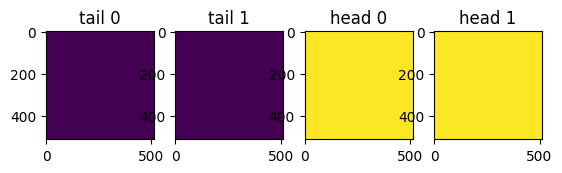

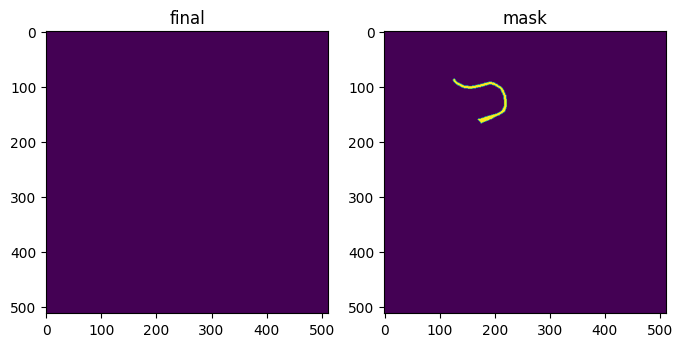

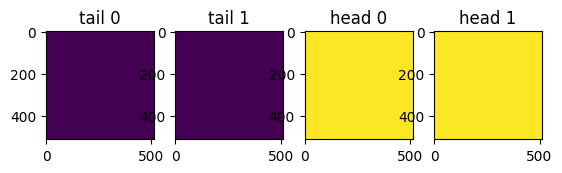

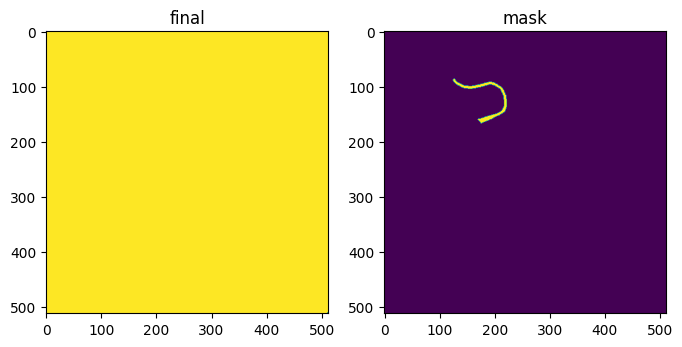

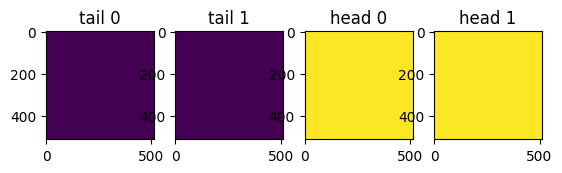

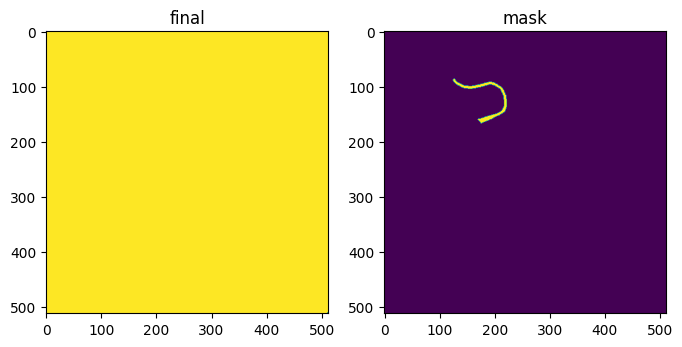

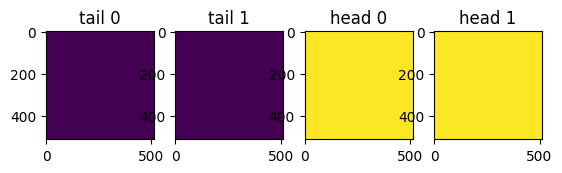

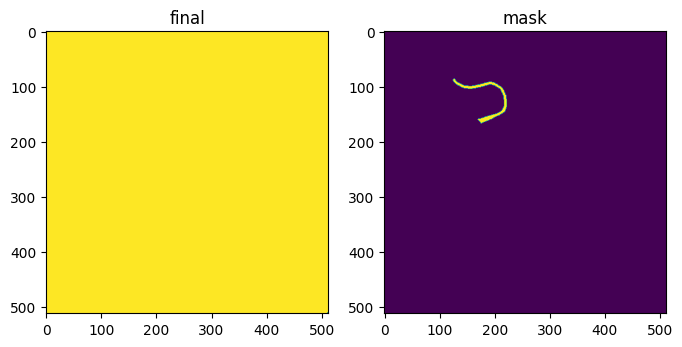

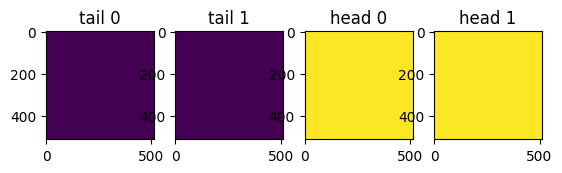

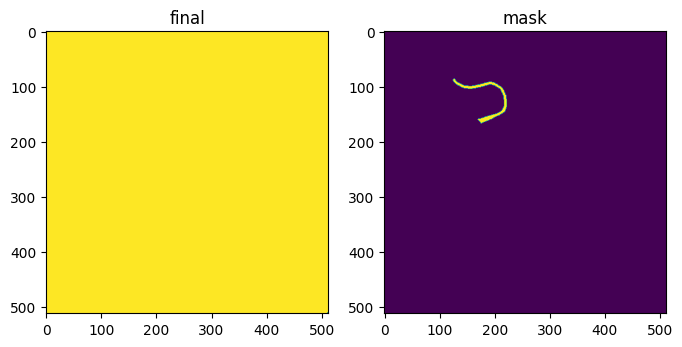

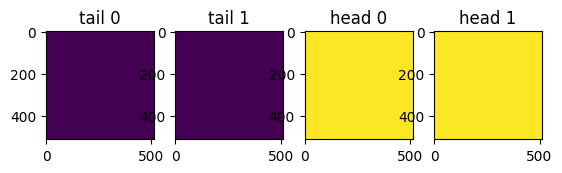

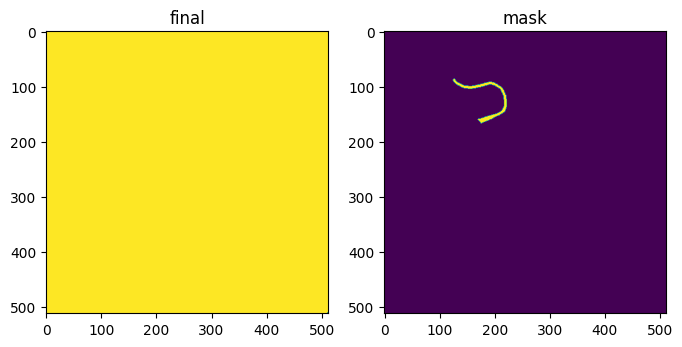

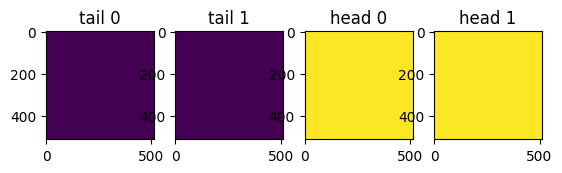

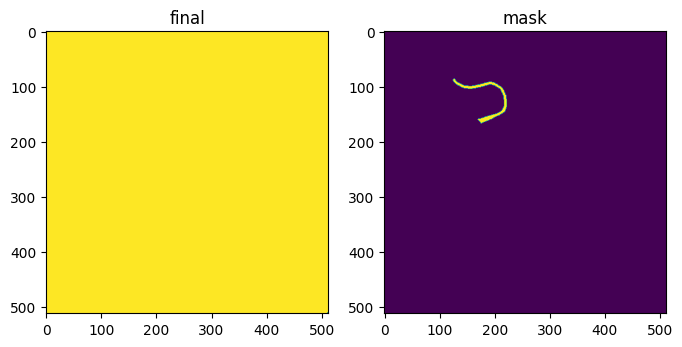

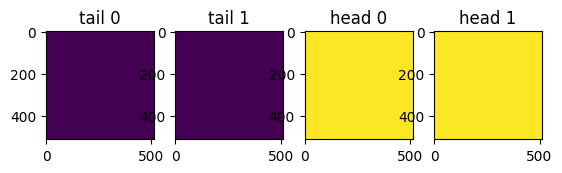

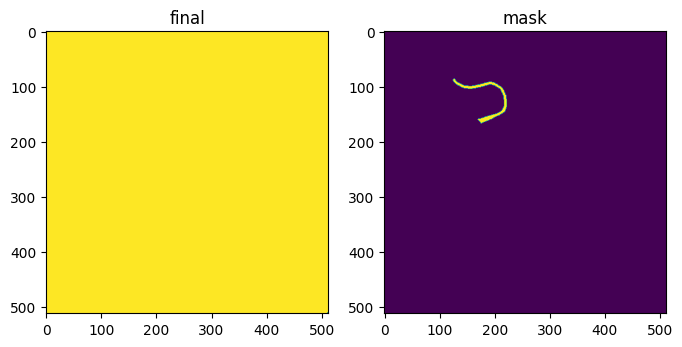

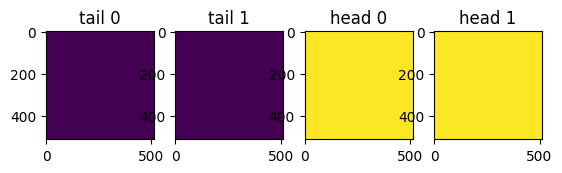

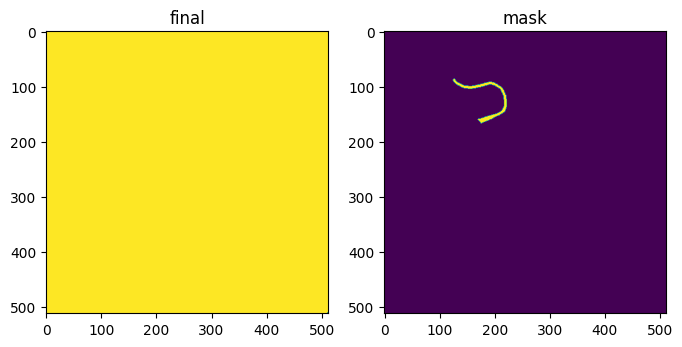

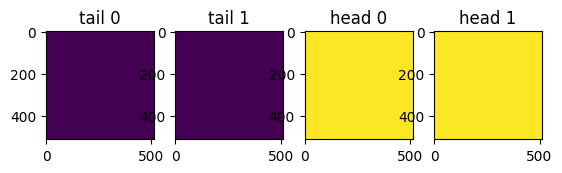

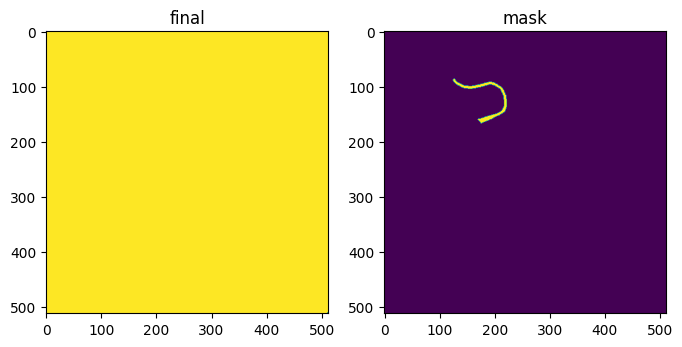

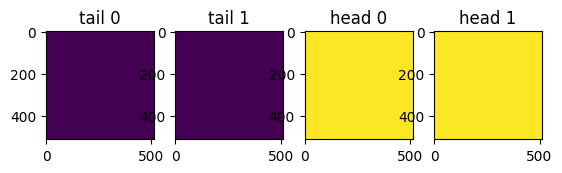

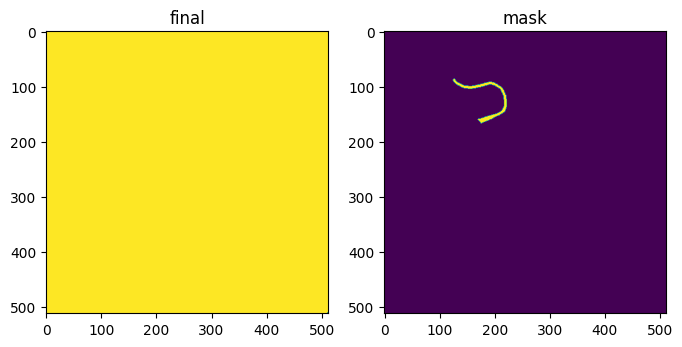

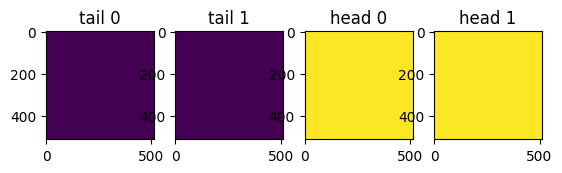

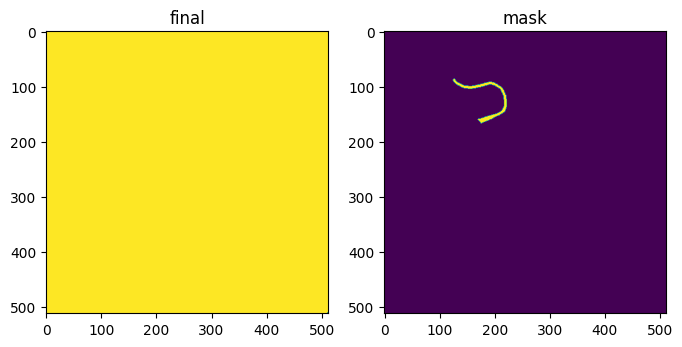

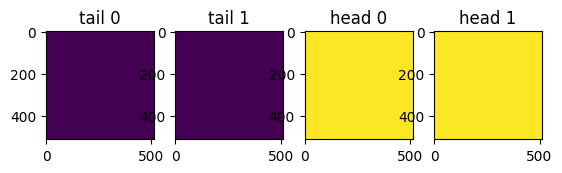

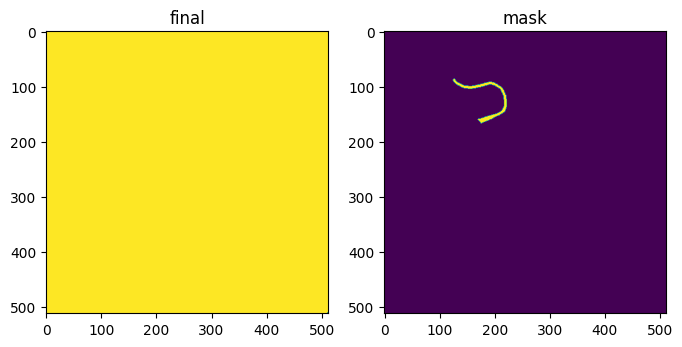

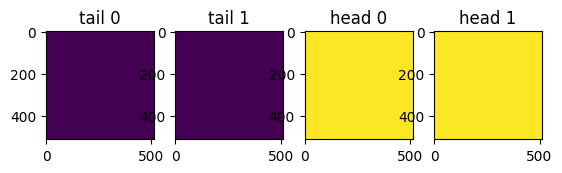

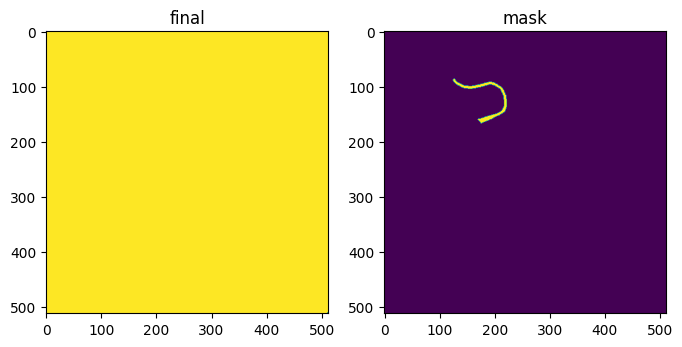

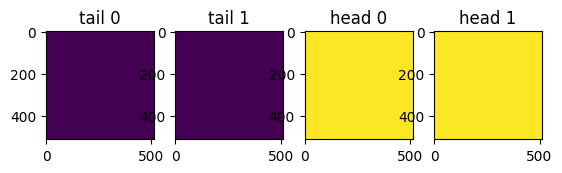

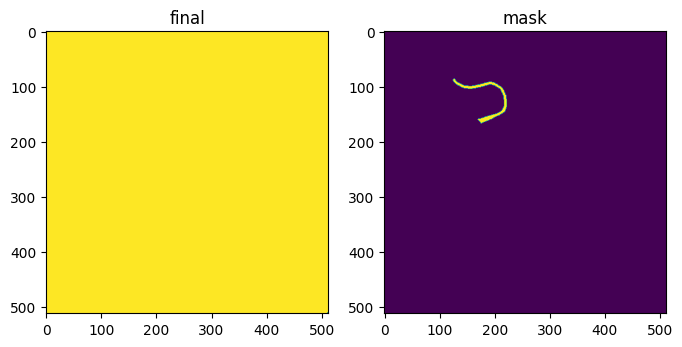

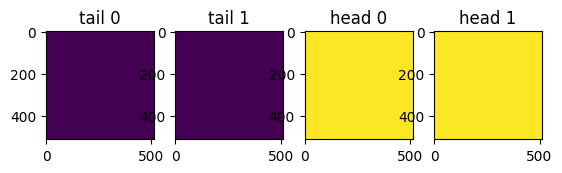

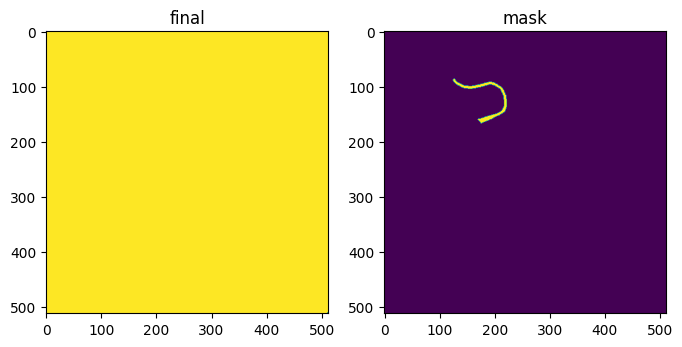

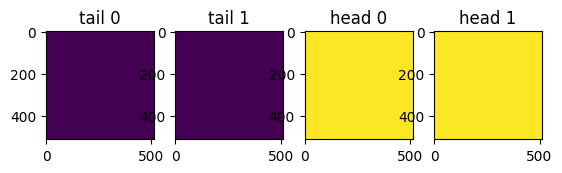

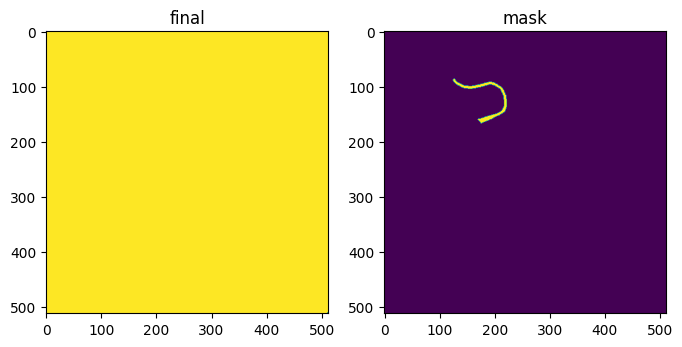

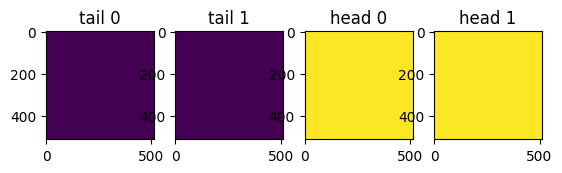

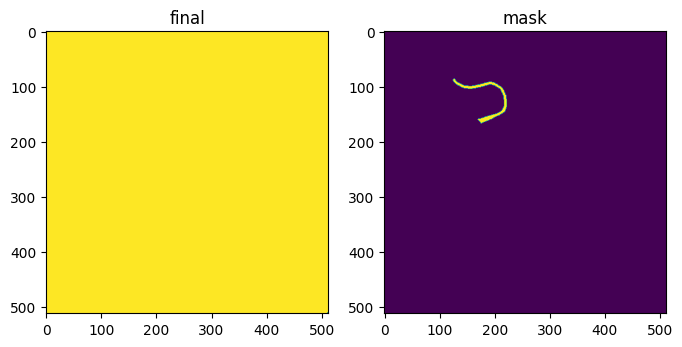

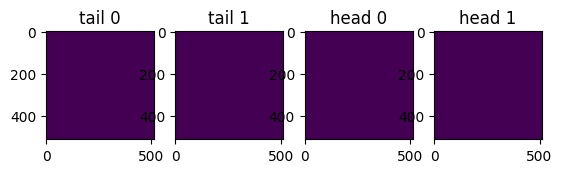

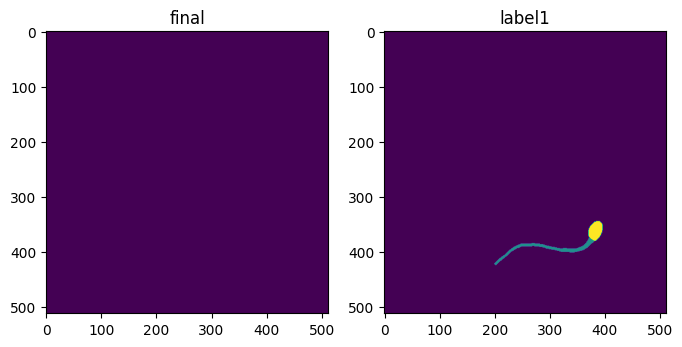

In [10]:
predict(model, test_loader)

In [11]:
def apply_threshold(mask, threshold = 0.9):
    return np.where(mask>threshold, 1, 0).astype(float)

In [12]:
device = torch.device("cuda")
from utils.transformation import transform_mask

torch.Size([1, 4, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([3, 512, 512])
torch.Size([2, 512, 512])
out1 torch.Size([1, 3, 512, 512])
out2 torch.Size([1, 2, 512, 512])
[0.0019455 0.       ]

torch.Size([1, 4, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([3, 512, 512])
torch.Size([2, 512, 512])
out1 torch.Size([1, 3, 512, 512])
out2 torch.Size([1, 2, 512, 512])
[0.00194931 0.        ]

torch.Size([1, 4, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size([3, 512, 512])
torch.Size([2, 512, 512])
out1 torch.Size([1, 3, 512, 512])
out2 torch.Size([1, 2, 512, 512])
[0.00194931 0.        ]

torch.Size([1, 4, 512, 512])
torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])
torch.Size([1, 512, 512])
torch.Size([1, 512, 512])
torch.Size(

C:\Users\Piotr\AppData\Local\Temp\ipykernel_7860\721427294.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(1, 2)


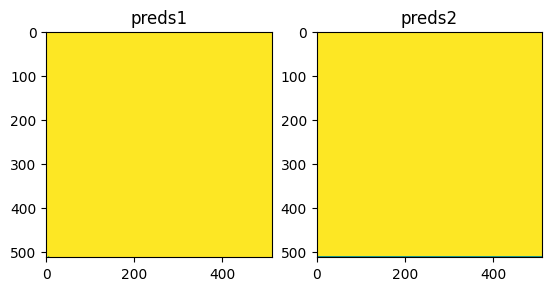

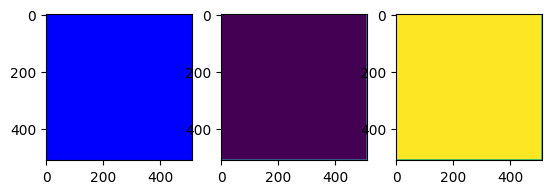

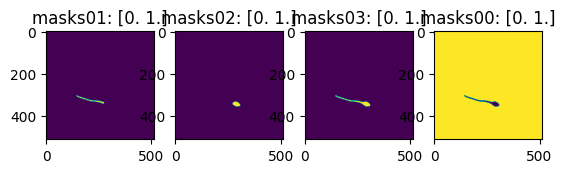

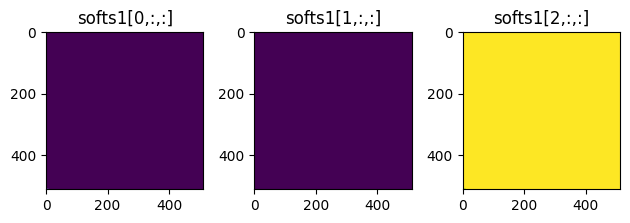

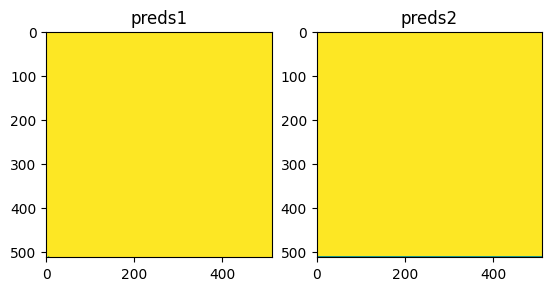

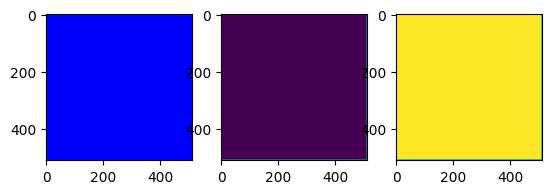

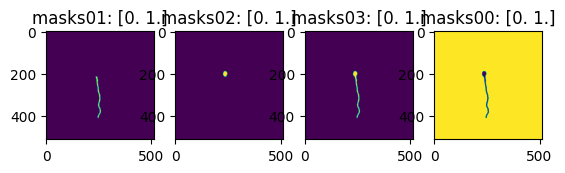

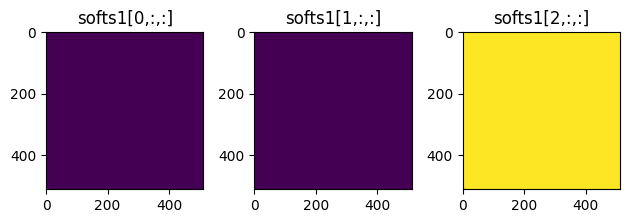

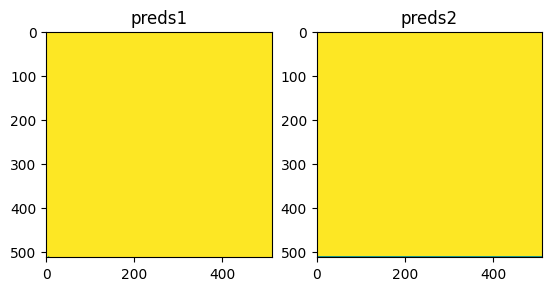

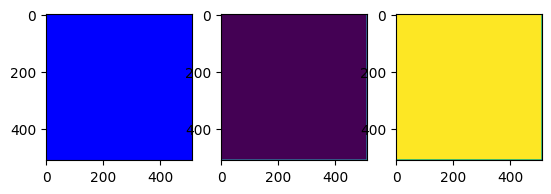

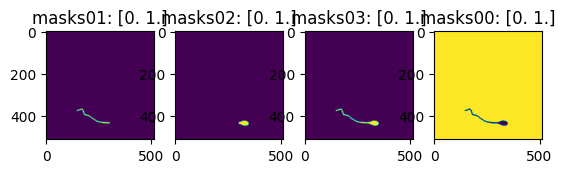

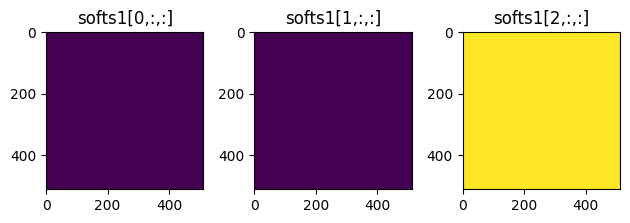

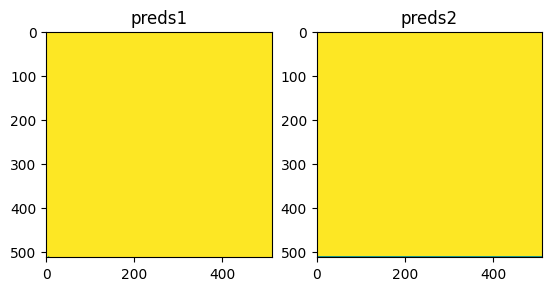

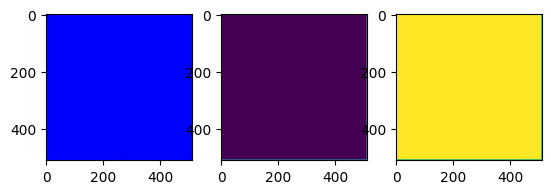

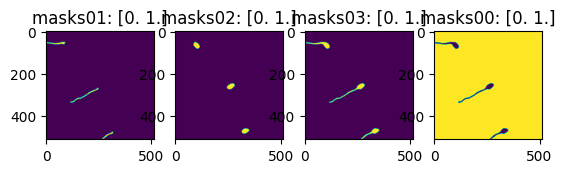

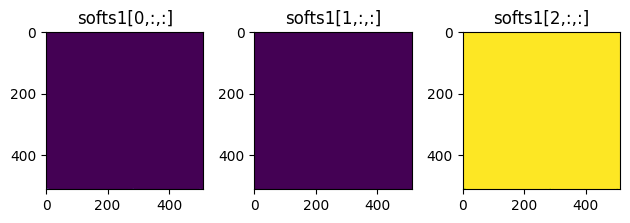

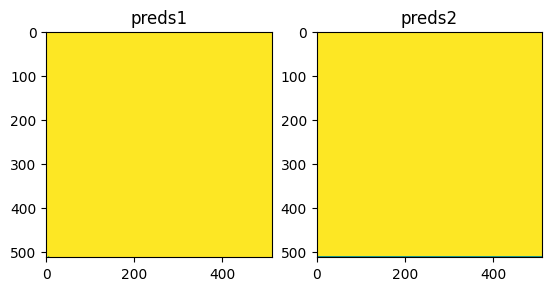

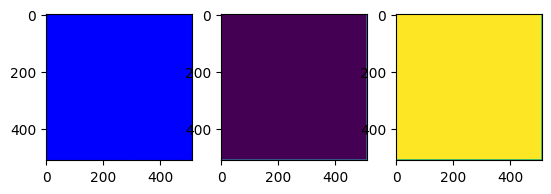

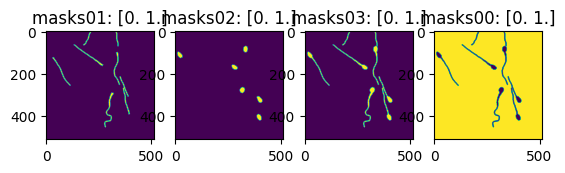

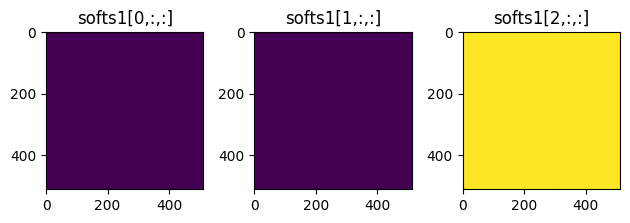

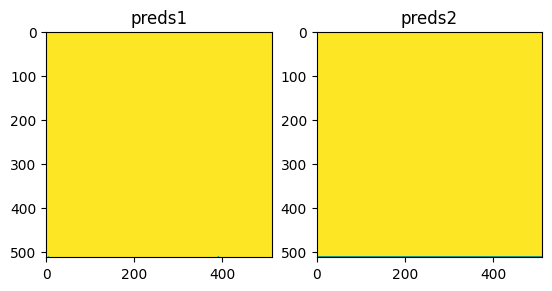

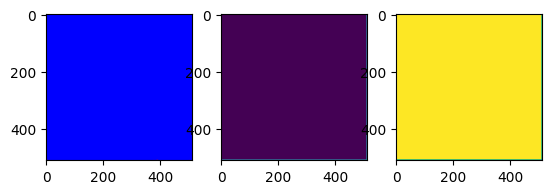

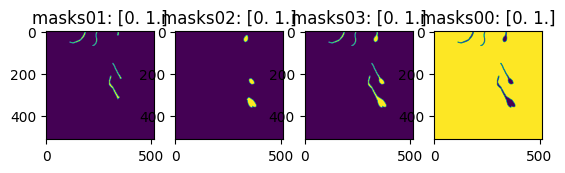

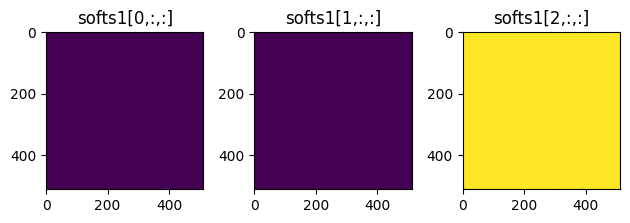

In [82]:
model.eval()
with torch.no_grad():
    model = model.to(device)
    for i, data in enumerate(test_loader):
        image, masks = data
        masks = np.array(masks.cpu())

        image = image.to(device)
        outputs = model(image)

        print(np.shape(outputs))
        
        output1 = outputs[:, :3, :, :]
        output2 = outputs[:, [0, -1], :, :]

        print(np.shape(output1))
        print(np.shape(output2))

        preds1 = torch.argmax(output1, dim=1)
        preds2 = torch.argmax(output2, dim=1)
        
        print(np.shape(preds1))
        print(np.shape(preds2))

        plt.subplots(1, 2)

        plt.subplot(1, 2, 1)
        plt.imshow(preds1.cpu().squeeze())
        plt.title("preds1")

        plt.subplot(1, 2, 2)
        plt.imshow(preds2.cpu().squeeze())
        plt.title("preds2")

        softs1 = torch.softmax(output1, dim=1).squeeze(0)
        softs2 = torch.softmax(output2, dim=1).squeeze(0)

        plt.subplots(1, 3)

        plt.subplot(1, 3, 1)
        plt.imshow(np.transpose(softs1.cpu(), axes=(1, 2, 0)))

        plt.subplot(1, 3, 2)
        plt.imshow(softs2[0,:,:].cpu())

        plt.subplot(1, 3, 3)
        plt.imshow(softs2[1,:,:].cpu())

            
        print(np.shape(softs1.cpu()))
        print(np.shape(softs2.cpu()))

        print("out1", np.shape(output1.cpu()))
        print("out2", np.shape(output2.cpu()))
        

        # plt.subplots(1, 2)

        # plt.subplot(1, 2, 1)
        # plt.imshow(np.transpose(output1.cpu().squeeze(), axes=(1, 2, 0)))

        # plt.subplot(1, 2, 2)
        # plt.imshow(np.transpose(output2.cpu().squeeze(), axes=(1, 2, 0)))
        
        # plt.subplots(1, 4)

        # plt.subplot(1, 4, 1)
        # plt.imshow(np.transpose(softs1.cpu(), axes=(1, 2, 0)))
        # plt.title("softs1")
        # plt.subplot(1, 4, 2)
        # plt.imshow(apply_threshold(softs2[0,:,:].cpu()))
        # plt.title("softs2[0,:,:]")
        # plt.subplot(1, 4, 3)
        # plt.imshow(apply_threshold(softs2[1,:,:].cpu()))
        # plt.title("softs2[1,:,:]")
        # plt.subplot(1,4,4)
        # plt.imshow(transform_mask(masks.squeeze(), 2))
        # plt.title("label")

        # plt.subplots(1, 3)
        # plt.subplot(1, 3, 1)
        # plt.imshow(apply_threshold(softs1[0,:,:].cpu()))
        # plt.title("softs1[0,:,:] t")
        
        # plt.subplot(1, 3, 2)
        # plt.imshow(apply_threshold(softs1[1,:,:].cpu()))
        # plt.title("softs1[1,:,:] t")
        
        # plt.subplot(1, 3, 3)
        # plt.imshow(apply_threshold(softs1[2,:,:].cpu()))
        # plt.title("softs1[2,:,:] t")

        iou, iou_list = calculate_iou(preds1.cpu() + preds2.cpu(), masks[0,1,:,:], 2)
        
        plt.subplots(1, 4)

        plt.subplot(1, 4, 1)
        plt.imshow(masks[0,1,:,:])
        plt.title(f"masks01: {np.unique(masks[0,1,:,:])}")

        plt.subplot(1, 4, 2)
        plt.imshow(masks[0,2,:,:])
        plt.title(f"masks02: {np.unique(masks[0,2,:,:])}")

        plt.subplot(1, 4, 3)
        plt.imshow(masks[0,3,:,:])
        plt.title(f"masks03: {np.unique(masks[0,3,:,:])}")
        
        plt.subplot(1, 4, 4)
        plt.imshow(masks[0,0,:,:])
        plt.title(f"masks00: {np.unique(masks[0,3,:,:])}")

        plt.subplots(1, 3)

        plt.subplot(1, 3, 1)
        plt.imshow(softs1[0, :, :].cpu())
        plt.title("softs1[0,:,:]")

        plt.subplot(1, 3, 2)
        plt.imshow(softs1[1,:,:].cpu())
        plt.title("softs1[1,:,:]")

        plt.subplot(1, 3, 3)
        plt.imshow(softs1[2,:,:].cpu())
        plt.title("softs1[2,:,:]")
        plt.tight_layout()

        # iou_tail, iou_tail_list = calculate_iou(softs1[1, :, :].cpu(), masks[0,1,:,:], 2)
        # print("tail",iou_tail)

        # iou_head, iou_head_list = calculate_iou(softs1[2, :, :].cpu(), masks[0,2,:,:], 2)
        # print("head",iou_head)

        # iou_full, iou_full_list = calculate_iou(softs1[3, :, :].cpu(), masks[0,3,:,:], 2)
        # print("full",iou_full)

        # iou_back, iou_back_list = calculate_iou(softs1[0,:,:].cpu(), masks[0,0,:,:], 2)
        # print("back",iou_back)
        
        
        print()
        if i == 5:
            break
        
        

In [14]:
np.shape(outputs)

torch.Size([1, 4, 512, 512])

In [15]:
np.shape(output1)

torch.Size([1, 3, 512, 512])

In [16]:
np.shape(output2)

torch.Size([1, 2, 512, 512])

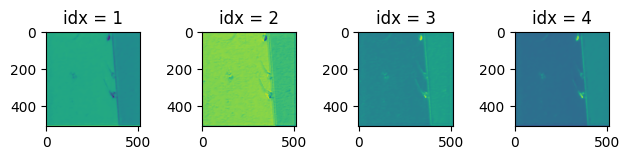

In [83]:
plt.subplots(1, 4)
for i in range(1, 5):
    plt.subplot(1, 4, i)
    plt.imshow(outputs[:, i-1, :, :].cpu().squeeze())
    plt.tight_layout()
    plt.title(f"idx = {i}")

In [18]:
# output1 = outputs[:, :3, :, :]
# output2 = outputs[:, [0, 1], :, :]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1914.3977..2757.674].


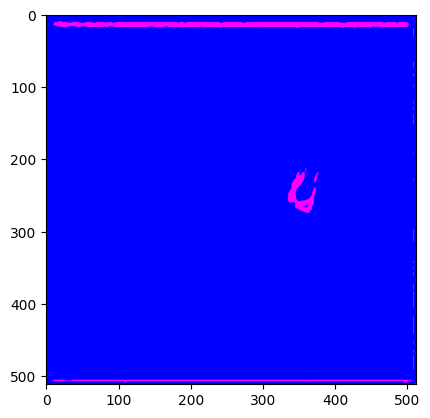

In [19]:
plt.imshow(np.transpose(outputs[:, :3,:,:].cpu().squeeze(), axes=(1,2,0)))

In [20]:
np.unique(softs2.cpu())

array([0.0000000e+00, 1.4012985e-45, 2.8025969e-45, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

In [21]:
np.unique(preds2.cpu())

array([0, 1], dtype=int64)

In [22]:
thresh = apply_threshold(softs1.cpu())

In [23]:
np.unique(thresh)

array([0., 1.])

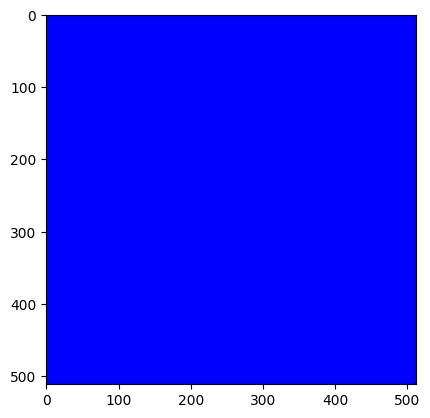

In [24]:
plt.imshow(np.transpose(thresh, axes=(1,2,0)))

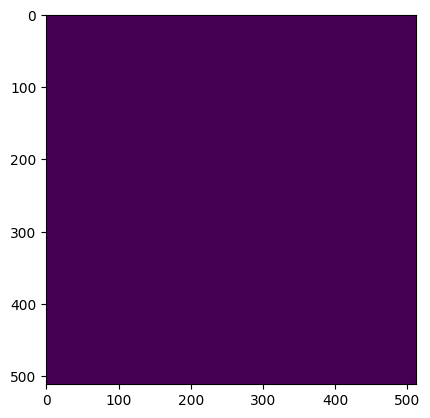

In [25]:
plt.imshow(thresh[0, :, :])

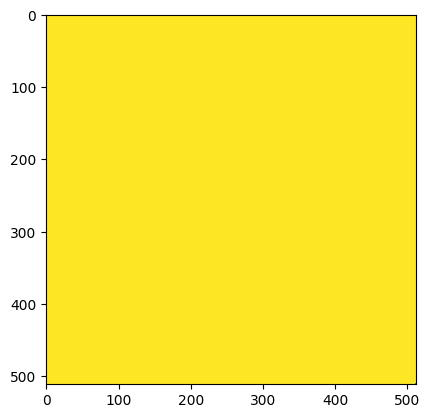

In [26]:
plt.imshow(preds1.cpu().squeeze())

In [27]:
np.unique(softs1.cpu())

array([0.00000000e+00, 1.40129846e-45, 2.80259693e-45, 4.20389539e-45,
       5.60519386e-45, 7.00649232e-45, 8.40779079e-45, 9.80908925e-45,
       1.12103877e-44, 1.26116862e-44, 1.40129846e-44, 1.54142831e-44,
       1.68155816e-44, 1.96181785e-44, 2.10194770e-44, 2.24207754e-44,
       2.38220739e-44, 2.66246708e-44, 2.94272678e-44, 3.08285662e-44,
       3.22298647e-44, 3.36311631e-44, 3.64337601e-44, 3.78350585e-44,
       4.06376555e-44, 4.62428493e-44, 4.76441478e-44, 5.04467447e-44,
       5.18480432e-44, 5.32493416e-44, 5.74532370e-44, 5.88545355e-44,
       6.30584309e-44, 6.86636248e-44, 7.42688186e-44, 7.56701171e-44,
       7.98740125e-44, 8.26766094e-44, 8.40779079e-44, 8.54792063e-44,
       8.82818033e-44, 8.96831017e-44, 9.38869971e-44, 9.52882956e-44,
       9.94921910e-44, 1.02294788e-43, 1.03696086e-43, 1.05097385e-43,
       1.09301280e-43, 1.12103877e-43, 1.13505176e-43, 1.14906474e-43,
       1.16307773e-43, 1.19110369e-43, 1.21912966e-43, 1.24715563e-43,
      

In [28]:
np.shape(softs1.cpu())

torch.Size([3, 512, 512])

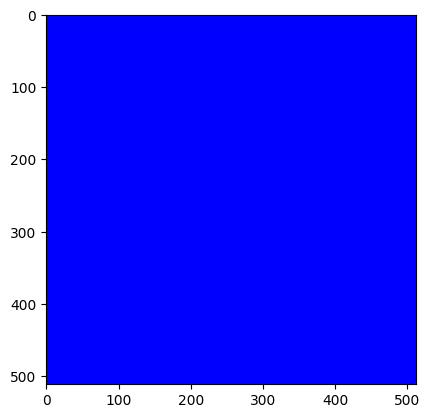

In [29]:
plt.imshow(np.transpose(softs1.cpu(), axes=(1, 2, 0)))

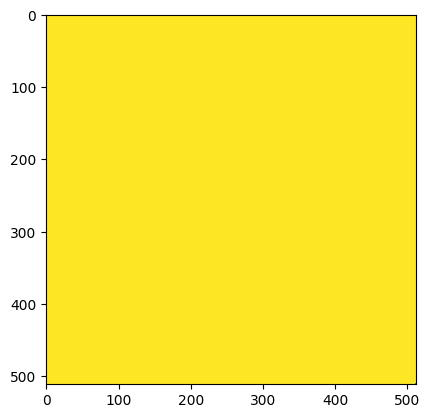

In [30]:
plt.imshow(softs1[2,:,:].cpu())

In [31]:
np.unique(softs1[0,:,:].cpu())

array([0.00000000e+00, 1.40129846e-45, 2.80259693e-45, 4.20389539e-45,
       5.60519386e-45, 7.00649232e-45, 8.40779079e-45, 9.80908925e-45,
       1.12103877e-44, 1.26116862e-44, 1.40129846e-44, 1.54142831e-44,
       1.68155816e-44, 1.96181785e-44, 2.10194770e-44, 2.24207754e-44,
       2.38220739e-44, 2.66246708e-44, 2.94272678e-44, 3.08285662e-44,
       3.22298647e-44, 3.36311631e-44, 3.64337601e-44, 3.78350585e-44,
       4.06376555e-44, 4.62428493e-44, 4.76441478e-44, 5.04467447e-44,
       5.18480432e-44, 5.32493416e-44, 5.74532370e-44, 5.88545355e-44,
       6.30584309e-44, 6.86636248e-44, 7.42688186e-44, 7.56701171e-44,
       7.98740125e-44, 8.26766094e-44, 8.40779079e-44, 8.54792063e-44,
       8.82818033e-44, 8.96831017e-44, 9.38869971e-44, 9.52882956e-44,
       9.94921910e-44, 1.02294788e-43, 1.03696086e-43, 1.05097385e-43,
       1.09301280e-43, 1.12103877e-43, 1.13505176e-43, 1.14906474e-43,
       1.16307773e-43, 1.19110369e-43, 1.21912966e-43, 1.24715563e-43,
      